* **This is a WIP colab**.
* TODO:
  - Verify compression ratios.
  - Add a histogram for centroids.
  - Try different distributions (uniform, normal, etc.) for compressing x.

# Clustering

This codelab gives a hands-on introduction to using clustering as a compression technique.

In [1]:
import numpy as np
import tensorflow as tf

In [20]:
def get_clustering_loss(x_var, centroids_var):
  """Computing the loss to optimize."""
  # Compute the pairwise squared distance between the input (x) and the
  # centroids.
  distances = tf.subtract(tf.reshape(x_var, (-1, 1)), centroids_var) ** 2
  best_distances = tf.math.reduce_min(distances, axis=1)
  return tf.reduce_mean(best_distances)

def get_centroids(x, num_clusters, num_steps=10, learning_rate=1e-3):
  """Get `num_clusters` centroids for the given value of `x`."""
  # Pick initial centroids that are evenly spaced.
  x_sorted = np.sort(x.flatten())
  centroids_init = np.linspace(x_sorted[0], x_sorted[-1], num_clusters)

  # Construct the variables in this optimization problem.
  # We will not update 'x', and hence it is not trainable.
  x_var = tf.Variable(initial_value=x_sorted, trainable=False)

  # The centroids are going to be updated, thus they will be trainable.
  centroids_var = tf.Variable(initial_value=centroids_init, trainable=True)

  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  for step_idx in range(num_steps):
    with tf.GradientTape() as tape:
      loss = get_clustering_loss(x_var, centroids_var)
      print(f'Step: {step_idx + 1}, Loss: {loss:.5f}.')

    # Compute the gradients w.r.t. only the centroids_var.
    gradients = tape.gradient(loss, [centroids_var])
    
    # Update the centroids_var.
    opt.apply_gradients(zip(gradients, [centroids_var]))
  return centroids_var


def encode_x(x, centroids):
  """Encode the given `x` using the given centroids."""
  x_flattened = tf.reshape(x, [-1])
  # Compute pairwise squared distances between all the elements of x and the
  # centroids.
  distances = tf.subtract(
      tf.reshape(x_flattened, (-1, 1)), 
      centroids) ** 2
  
  # Now compute the distance to the closest centroid.
  best_distances = tf.math.reduce_min(distances, axis=1)
  
  # Create an indicator variable matrix, where 1.0 at index [i][j] denotes that
  # for the i-th element, the j-th centroid is the closest.
  is_closest = tf.cast(
    tf.equal(distances, tf.reshape(best_distances, (-1, 1))),
    dtype=tf.float64)
  
  # Now lookup the centroid indices.
  encoded_x_flattened = tf.math.argmax(is_closest, axis=1)

  # Finally, reshape the array to the original shape.
  return tf.reshape(encoded_x_flattened, tf.shape(x))


def decode_x(encoded_x, centroids):
  """Decode the x back from the centroids."""
  encoded_x_flattened = tf.reshape(encoded_x, [-1])
  # Lookup the centroids for their values, and then reshape it back to the
  # original shape.
  return tf.reshape(
      tf.gather(centroids, encoded_x),
      tf.shape(encoded_x))


def compute_reconstruction_loss(x, decoded_x, sqrt=False):
  """Compute a simple mean squared error (MSE) loss."""
  loss = tf.math.reduce_mean((x - decoded_x)**2)

  # In some cases we return the RMSE instead of MSE if needed. This is helpful
  # for easy comparison if the loss is really small.
  return tf.sqrt(loss) if sqrt else loss

In [21]:
# Setting a seed here helps us reproduce the same output over multiple runs.
np.random.seed(1337)
x = np.random.random((32, 32))
num_clusters = 4
print('Computing the centroids.')
computed_centroids = get_centroids(x, num_clusters, num_steps=20, 
                                   learning_rate=5e-3)
print('Encoding `x` using the computed centroids.')
encoded_x = encode_x(x, computed_centroids)

# Now finally decode the encoded x, and compute the reconstruction loss.
print('Decoding `x` using the computed centroids.')
decoded_x = decode_x(encoded_x, computed_centroids)
reconstruction_loss = compute_reconstruction_loss(x, decoded_x)
print(f'Final reconstruction loss: {reconstruction_loss:.4f}.')

Computing the centroids.
Step: 1, Loss: 0.00913.
Step: 2, Loss: 0.00913.
Step: 3, Loss: 0.00912.
Step: 4, Loss: 0.00911.
Step: 5, Loss: 0.00910.
Step: 6, Loss: 0.00910.
Step: 7, Loss: 0.00909.
Step: 8, Loss: 0.00908.
Step: 9, Loss: 0.00907.
Step: 10, Loss: 0.00907.
Step: 11, Loss: 0.00906.
Step: 12, Loss: 0.00905.
Step: 13, Loss: 0.00904.
Step: 14, Loss: 0.00904.
Step: 15, Loss: 0.00903.
Step: 16, Loss: 0.00902.
Step: 17, Loss: 0.00901.
Step: 18, Loss: 0.00901.
Step: 19, Loss: 0.00900.
Step: 20, Loss: 0.00899.
Encoding `x` using the computed centroids.
Decoding `x` using the computed centroids.
Final reconstruction loss: 0.0090.


# Mars Rover Problem

In this section, we will revisit the Mars Rover problem to demonstrate how does Clustering compare to Quantization.

In [22]:
! wget https://github.com/EfficientDL/book/raw/main/codelabs/Chapter-02-Compression-Techniques/pia23378-16.jpeg

--2022-07-19 16:37:55--  https://github.com/EfficientDL/book/raw/main/codelabs/Chapter-02-Compression-Techniques/pia23378-16.jpeg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/EfficientDL/book/main/codelabs/Chapter-02-Compression-Techniques/pia23378-16.jpeg [following]
--2022-07-19 16:37:55--  https://raw.githubusercontent.com/EfficientDL/book/main/codelabs/Chapter-02-Compression-Techniques/pia23378-16.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129737 (127K) [image/jpeg]
Saving to: ‘pia23378-16.jpeg.1’

pia23378-16.jpeg.1  100%[===================>] 126.70K  --.-KB/s    in 0.02s   



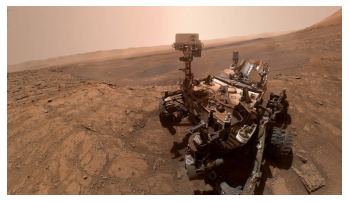

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = (mpimg.imread('pia23378-16.jpeg') / 255.0)
plt.axis('off')
plt.imshow(img)

## Quantization helper functions.

These are helper methods from the quantization colab in Chapter 2. Nothing new to see here, but we included these methods in this colab to compare against clustering.

In [24]:
def get_scale(x_min, x_max, b):
  # Compute scale as discussed.
  return (x_max - x_min ) * 1.0 / (2**b)

"""Quantizing the given vector x."""
def quantize(x, x_min, x_max, b):
  # Clamp x to lie in [x_min, x_max].
  x = np.minimum(x, x_max)
  x = np.maximum(x, x_min)

  # Compute scale as discussed.
  s = get_scale(x_min, x_max, b)
  x_q = np.floor((x - x_min) / s)

  # Clamping the quantized value to be less than (2^b - 1).
  x_q = np.minimum(x_q, 2**b - 1)

  # Return x_q as an unsigned integer.
  # uint8 is the smallest data type supported by numpy.
  return x_q.astype(np.uint8)

def dequantize(x_q, x_min, x_max, b):
  # Compute the value of r the same way.
  s = get_scale(x_min, x_max, b)
  x = x_min + (s * x_q)
  return x

In [25]:
def simulate_transmission_quantization(img, b):
  transmitted_image = quantize(img, 0.0, 1.0, b)
  decoded_image = dequantize(transmitted_image, 0.0, 1.0, b)
  plt.axis('off')
  plt.imshow(decoded_image)
  print('Reconstruction Loss: '
        f'{compute_reconstruction_loss(img, decoded_image):.5f}') 

Reconstruction Loss: 0.00031


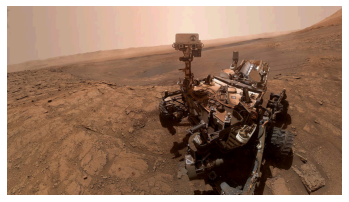

In [26]:
num_bits = 5
simulate_transmission_quantization(img, num_bits)

Reconstruction Loss: 0.00126


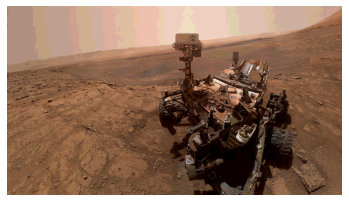

In [27]:
simulate_transmission_quantization(img, 4)

The reconstruction loss with 5 bits is 0.01756. If we reduce the number of bits further, the image starts to get blurry.

## Can we do better with clustering? 

The goal in this scenario is to use clustering to outperform quantization. Let us implement a method that simulates the transmission and measures the reconstruction loss.

In [28]:
def simulate_transmission_clustering(img, num_clusters):
  x = img
  print('Computing the centroids.')
  computed_centroids = get_centroids(x, num_clusters, num_steps=100, 
                                   learning_rate=5e-3)
  print('Encoding `x` using the computed centroids.')
  encoded_x = encode_x(x, computed_centroids)
  print('Decoding `x` using the computed centroids.')
  decoded_x = decode_x(encoded_x, computed_centroids)
  reconstruction_loss = compute_reconstruction_loss(x, decoded_x)
  print(f'Reconstruction loss: {reconstruction_loss:.4f}.')

  print(computed_centroids)
  decoded_image = decoded_x
  plt.axis('off')
  plt.imshow(decoded_image) 

Let us try clustering with 16 clusters and centroids.

Computing the centroids.
Step: 1, Loss: 0.00022.
Step: 2, Loss: 0.00022.
Step: 3, Loss: 0.00022.
Step: 4, Loss: 0.00022.
Step: 5, Loss: 0.00022.
Step: 6, Loss: 0.00022.
Step: 7, Loss: 0.00022.
Step: 8, Loss: 0.00022.
Step: 9, Loss: 0.00022.
Step: 10, Loss: 0.00022.
Step: 11, Loss: 0.00022.
Step: 12, Loss: 0.00022.
Step: 13, Loss: 0.00022.
Step: 14, Loss: 0.00022.
Step: 15, Loss: 0.00022.
Step: 16, Loss: 0.00022.
Step: 17, Loss: 0.00022.
Step: 18, Loss: 0.00022.
Step: 19, Loss: 0.00022.
Step: 20, Loss: 0.00022.
Step: 21, Loss: 0.00022.
Step: 22, Loss: 0.00022.
Step: 23, Loss: 0.00022.
Step: 24, Loss: 0.00022.
Step: 25, Loss: 0.00022.
Step: 26, Loss: 0.00022.
Step: 27, Loss: 0.00022.
Step: 28, Loss: 0.00022.
Step: 29, Loss: 0.00022.
Step: 30, Loss: 0.00022.
Step: 31, Loss: 0.00022.
Step: 32, Loss: 0.00022.
Step: 33, Loss: 0.00022.
Step: 34, Loss: 0.00022.
Step: 35, Loss: 0.00022.
Step: 36, Loss: 0.00022.
Step: 37, Loss: 0.00022.
Step: 38, Loss: 0.00022.
Step: 39, Loss: 0.00022.
Step: 40,

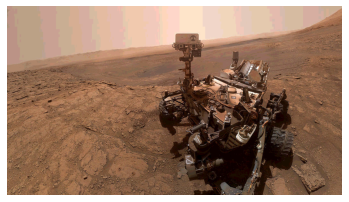

In [29]:
num_clusters = 20
simulate_transmission_clustering(img, num_clusters)

Notice that the reconstruction loss using clustering with 16 clusters (0.0172) is slightly lower than that using quantization with 5 bits (0.01756). 

In [30]:
# Compute various statistics related to size when using quantization /
# clustering.

def get_quantized_size_bytes(num_elements, num_quantization_bits):
  # num_elements = img.size
  return (num_elements * num_quantization_bits) / 8.0

def get_clustered_size_bytes(num_elements, num_clusters,
                             floating_point_word_size=4):
  codebook_size_bytes = num_clusters * floating_point_word_size
  encoded_img_size_bytes = (num_elements * np.math.log2(num_clusters)) / 8.0
  return codebook_size_bytes + encoded_img_size_bytes


def compute_compression_ratio(num_elements, num_quantization_bits, num_clusters, 
                              floating_point_word_size=4):
  original_size_bytes = num_elements * floating_point_word_size
  quantized_size_bytes = get_quantized_size_bytes(num_elements, num_bits)
  clustered_size_bytes = get_clustered_size_bytes(num_elements, 
                                                  num_clusters)
  quant_vs_clustering_compression_ratio = (quantized_size_bytes * 1.0 / 
                                           clustered_size_bytes)
  original_vs_clustering_compression_ratio = (original_size_bytes * 1.0 /
                                              clustered_size_bytes)
  
  print(f'Original input size: {original_size_bytes} bytes.')
  print(f'Quantized input size: {quantized_size_bytes} bytes.')
  print(f'Clustered input size: {clustered_size_bytes} bytes.')
  print('Compression Ratio (Quant Size / Clustered Size): '
        f'{quant_vs_clustering_compression_ratio:.3f}.')

In [31]:
compute_compression_ratio(img.size, num_bits, num_clusters)

Original input size: 7320312 bytes.
Quantized input size: 1143798.75 bytes.
Clustered input size: 988763.1905044094 bytes.
Compression Ratio (Quant Size / Clustered Size): 1.157.


Clustering thus leads to a **1.25x smaller representation** as compared to quantization while achieving a similar reconstruction loss.

# Simulating clustering on a dummy dense fully-connected layer

In [33]:
np.random.seed(10007)

def get_random_matrix(shape):
  return np.random.uniform(low=-1.0, high=1.0, size=shape)

# Populate the inputs, weights and bias.
inputs = get_random_matrix([100,300])
weights = get_random_matrix([300,500])
bias = get_random_matrix([500])

y = np.matmul(inputs, weights) + bias
print(y)

[[  5.1454453    8.32010738  -1.9247047  ...   1.68650849  -4.63663791
    0.40184778]
 [ -3.39431111  -4.1201795   11.12798817 ...   2.9348677  -11.12313219
   -6.31953725]
 [ -2.89818284   8.41954327   5.32763659 ...   9.83619827   7.2085035
   -1.3993603 ]
 ...
 [ -1.16046206  -2.93545186   4.87193849 ...   0.34176615   3.01040254
   -4.49882702]
 [  5.74281052   5.99752446  -0.14589101 ...  -6.4838046    0.62067821
   -5.06578082]
 [  5.25901235  -4.16722325   2.03813712 ...   0.27043785  -5.1425765
   -1.94972811]]


## Using quantization with the dummy dense layer.

Let's measure the reconstruction losses when using quantization.

In [37]:
w_min = np.min(weights)
w_max = np.max(weights)
num_bits = 8

weights_quantized = quantize(weights, w_min, w_max, num_bits)
weights_dequantized = dequantize(weights_quantized, w_min, w_max, num_bits)
weights_reconstruction_loss_quant = compute_reconstruction_loss(
    weights, weights_dequantized).numpy()
print(f'Weights reconstruction loss: {weights_reconstruction_loss_quant:.5f}')

y_via_quant = np.maximum(np.matmul(inputs, weights_dequantized) + bias, 0)
output_reconstruction_loss_quant = compute_reconstruction_loss(
    y, y_via_quant).numpy()
print(f'Output reconstruction loss: {output_reconstruction_loss_quant:.4f}')

Weights reconstruction loss: 0.00002
Output reconstruction loss: 17.2370


## Using clustering with the dummy dense layer.

In [38]:
def weights_cluster(weights, num_clusters):
  x = weights
  print('Computing the centroids.')
  computed_centroids = get_centroids(weights, num_clusters, num_steps=50, 
                                   learning_rate=1e-2)
  print('Encoding weights using the computed centroids.')
  encoded_x = encode_x(x, computed_centroids)
  
  return encoded_x, computed_centroids

num_clusters = 48
encoded_weights, weight_centroids = weights_cluster(weights, 
                                                    num_clusters=num_clusters)
weights_from_clustering = decode_x(encoded_weights, weight_centroids)
compute_reconstruction_loss(weights, weights_from_clustering)
weights_reconstruction_loss_clustering = compute_reconstruction_loss(
    weights, weights_from_clustering).numpy()
print('Weights reconstruction loss: '
      f'{weights_reconstruction_loss_clustering:.4f}')

Computing the centroids.
Step: 1, Loss: 0.00015.
Step: 2, Loss: 0.00015.
Step: 3, Loss: 0.00015.
Step: 4, Loss: 0.00015.
Step: 5, Loss: 0.00015.
Step: 6, Loss: 0.00015.
Step: 7, Loss: 0.00015.
Step: 8, Loss: 0.00015.
Step: 9, Loss: 0.00015.
Step: 10, Loss: 0.00015.
Step: 11, Loss: 0.00015.
Step: 12, Loss: 0.00015.
Step: 13, Loss: 0.00015.
Step: 14, Loss: 0.00015.
Step: 15, Loss: 0.00015.
Step: 16, Loss: 0.00015.
Step: 17, Loss: 0.00015.
Step: 18, Loss: 0.00015.
Step: 19, Loss: 0.00015.
Step: 20, Loss: 0.00015.
Step: 21, Loss: 0.00015.
Step: 22, Loss: 0.00015.
Step: 23, Loss: 0.00015.
Step: 24, Loss: 0.00015.
Step: 25, Loss: 0.00015.
Step: 26, Loss: 0.00015.
Step: 27, Loss: 0.00015.
Step: 28, Loss: 0.00015.
Step: 29, Loss: 0.00015.
Step: 30, Loss: 0.00015.
Step: 31, Loss: 0.00015.
Step: 32, Loss: 0.00015.
Step: 33, Loss: 0.00015.
Step: 34, Loss: 0.00015.
Step: 35, Loss: 0.00015.
Step: 36, Loss: 0.00015.
Step: 37, Loss: 0.00015.
Step: 38, Loss: 0.00015.
Step: 39, Loss: 0.00015.
Step: 40,

In [39]:
y_via_clustering = np.maximum(np.matmul(inputs, weights_from_clustering) + bias, 0)
output_reconstruction_loss_clustering = compute_reconstruction_loss(
    y, y_via_clustering).numpy()
print(f'Output reconstruction loss: {output_reconstruction_loss_clustering:.4f}')

Output reconstruction loss: 17.2434


Let us now compute the compression ratio v/s quantization for the dense layer.

In [40]:
compute_compression_ratio(weights.size, num_bits, num_clusters)

Original input size: 600000 bytes.
Quantized input size: 150000.0 bytes.
Clustered input size: 104910.04688852168 bytes.
Compression Ratio (Quant Size / Clustered Size): 1.430.


Clustering achieves a very similar output reconstruction loss as quantization, and leads to a weights encoding that is almost **1.43x smaller**. 

However, note that if the size of the weight matrix was very small, the size of the codebook would have dominated the total size of the encoded representation. Since our weight matrix was reasonable (100x300), it allowed us to save space when compared to quantization.